In [1]:
import distutils.util as distutils
import os
import mujoco
import time
import itertools
import numpy as np
import matplotlib.pyplot as plt
import mediapy as media

all_variables = dir()
for name in all_variables:
    
    # Print the item if it doesn't start with '__'
    if not name.startswith('__'):
        if name == 'renderer':
            del renderer
        elif name == 'xml':
            del xml
        elif name == 'model':
            del model
        elif name == 'data':
            del data

In [2]:
q0_init = -np.pi/2
q1_init = 0
q0_end = np.pi/2
q1_end = -np.pi/2

t_init = 1
t_end = 2

t = []
qact0 = []
qref0 = []
qact1 = []
qref1 = []

The cubic polynomial trajectory is given by:
$$ q(t) = a_0 + a_1 t + a_2 t^2 + a_3 t^3 $$

Boundary conditions:
$$ q(t = t_0) = q_0 \\
q(t = t_f) = q_f \\
 \dot{q}(t = t_0) = 0 \\
\dot{q}(t = t_f) = 0 $$

Solving for $a_i$'s:
$$
\begin{aligned}
\begin{bmatrix}
a_0 \\
a_1 \\
a_2 \\
a_3 \\
\end{bmatrix}
=
\frac{1}
{(t_f - t_0)^3}
\begin{bmatrix}
q_f t_0^2 (3t_f - t_0) + q_0 t_f^2 (t_f - 3t_0) \\
6t_0 t_f (q_0 - q_f) \\
3(t_f + t_0) (q_f - q_0) \\
2(q_0 - q_f) \\
\end{bmatrix}
\end{aligned}
$$

In [3]:
def generate_trajectory(t0, tf, q0, qf):
    tf_t0_3 = (tf - t0)**3
    a0 = qf*(t0**2)*(3*tf-t0) + q0*(tf**2)*(tf-3*t0)
    a0 = a0 / tf_t0_3

    a1 = 6 * t0 * tf * (q0 - qf)
    a1 = a1 / tf_t0_3

    a2 = 3 * (t0 + tf) * (qf - q0)
    a2 = a2 / tf_t0_3

    a3 = 2 * (q0 - qf)
    a3 = a3 / tf_t0_3

    return a0, a1, a2, a3

def init_controller(model,data):
    #initialize the controller here. This function is called once, in the beginning
    #pass
    global a_jnt0, a_jnt1

    a_jnt0 = generate_trajectory(
        t_init, t_end, q0_init, q0_end)

    a_jnt1 = generate_trajectory(
        t_init, t_end, q1_init, q1_end)

def controller(model, data):
    #put the controller here. This function is called inside the simulation.
    #pass
    global a_jnt0, a_jnt1

    time = data.time

    if (time>t_end):
        time = t_end

    if (time<t_init):
        time = t_init

    q_ref0 = a_jnt0[0] + a_jnt0[1]*time + \
        a_jnt0[2]*(time**2) + a_jnt0[3]*(time**3)

    qdot_ref0 = a_jnt0[1] + 2 * a_jnt0[2] * \
        time + 3 * a_jnt0[3]*(time**2)

    q_ref1 = a_jnt1[0] + a_jnt1[1]*time + \
        a_jnt1[2]*(time**2) + a_jnt1[3]*(time**3)

    qdot_ref1 = a_jnt1[1] + 2 * a_jnt1[2] * \
        time + 3 * a_jnt1[3]*(time**2)

    #pd control
    # data.ctrl[0] = -500*(data.qpos[0]-q_ref0)-50*(data.qvel[0]-qdot_ref0)
    # data.ctrl[1] = -500*(data.qpos[1]-q_ref1)-50*(data.qvel[1]-qdot_ref1)

    #model-based control (feedback linearization)
    #tau = M*(PD-control) + f
    M = np.zeros((2,2))
    mujoco.mj_fullM(model,M,data.qM)
    f0 = data.qfrc_bias[0]
    f1 = data.qfrc_bias[1]
    f = np.array([f0,f1])

    kp = 500
    kd = 2*np.sqrt(kp)
    pd_0 = -kp*(data.qpos[0]-q_ref0)-kd*(data.qvel[0]-qdot_ref0)
    pd_1 = -kp*(data.qpos[1]-q_ref1)-kd*(data.qvel[1]-qdot_ref1)
    pd_control = np.array([pd_0,pd_1])
    tau_M_pd_control = np.matmul(M,pd_control)
    tau = np.add(tau_M_pd_control,f)
    data.ctrl[0] = tau[0]
    data.ctrl[1] = tau[1]

    t.append(data.time)
    qact0.append(data.qpos[0])
    qref0.append(q_ref0)
    qact1.append(data.qpos[1])
    qref1.append(q_ref1)

""

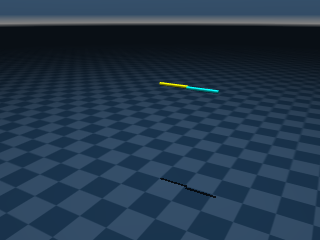

In [4]:
model = mujoco.MjModel.from_xml_path('model/2D_double_pendulum.xml')
data = mujoco.MjData(model)
cam = mujoco.MjvCamera()
data.qpos[0] = q0_init
data.qpos[1] = q1_init
renderer = None
renderer = mujoco.Renderer(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

In [5]:

#initialize the controller
init_controller(model,data)

#set the controller
mujoco.set_mjcb_control(controller)


In [6]:
# Parameters.
DURATION = 5         # seconds
FRAMERATE = 60        # Hz

# Reset data, set initial pose.
mujoco.mj_resetData(model, data)

# Allocate position difference dq.
dq = np.zeros(model.nv)

frames = []
while data.time < DURATION:

  # Step the simulation.
  mujoco.mj_step(model, data)

  # Render and save frames.
  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, 'track')
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames[20:], fps=FRAMERATE)